<a id="top"></a>
# Content


### 1. [Map Reduce](#map-reduce)

### 2. [Short Term vs Long Term Memory](#short-term-vs-long-term-memory)

### 3. [Chatbot with Profile Schema](#chatbot-with-profile-schema)

### 4. [Chatbot with Profile Collection](#chatbot-with-profile-collection)


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from src.utilities.llm_utils import (
    LLMResponse,
    convert_openai_messages_to_string,
    convert_to_openai_messages,
)  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

In [5]:
check_rate_limit()

{
  "data": {
    "label": "sk-or-v1-902...c45",
    "limit": 5,
    "usage": 3.7436591165,
    "is_provisioning_key": false,
    "limit_remaining": 1.2563408835,
    "is_free_tier": false,
    "rate_limit": {
      "requests": 20,
      "interval": "10s"
    }
  }
}


<br>

### LangGraph Imports

In [6]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.langchain import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [7]:
from langchain_core.language_models.chat_models import BaseChatModel

subject_prompt: str = """
<system>

Generate a list of 3 sub-topics that are all 
related to this overall topic:

<topic>
{topic!r} 
</topic>

</system>
"""

joke_prompt: str = """
<system>
Generate a joke about:

<subject>
{subject!r}
</subject>

</system>
"""

best_joke_prompt: str = """
<system>
Below are a bunch of jokes about:

<topic>
{topic!r}.
</topic>

Select the best one! Return the ID of the best one, starting 0 
as the ID for the first joke. 
<jokes>
{jokes}
</jokes>

<output>
Return the ID of the best joke as an integer.
</output>

</system>
"""

### Initialize the LLM

In [8]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE.value,  # noqa: E501
)
console.print(llm)

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model='meta-llama/llama-3.1-8b-instruct'
)

In [9]:
messages: list[dict[str, str]] = [
    {
        "role": "system",
        "content": subject_prompt.format(topic="Types of animals"),
    }
]

(response, raw_response) = await llm.ainvoke(messages=messages)
console.print(f"Raw response: {raw_response}")
console.print(f"Response: {response}")

Raw response: ChatCompletion(id='gen-1750629472-n7j8VIqehJwBDHISojGX', choices=[Choice(finish_reason='stop', 
index=0, logprobs=None, message=ChatCompletionMessage(content="<system>\n\nHere are 3 sub-topics related to 'Types 
of animals':\n\n1. **Mammals**: This sub-topic includes animals that are warm-blooded, have hair or fur, and 
produce milk to feed their young. Examples of mammals include lions, elephants, and humans.\n\n2. **Birds**: This 
sub-topic includes animals that have feathers, wings, and lay eggs. Examples of birds include eagles, parrots, and 
robins.\n\n3. **Reptiles**: This sub-topic includes animals that have scales, lay eggs, and are cold-blooded. 
Examples of reptiles include snakes, lizards, and turtles.\n\n</system>", refusal=None, role='assistant', 
annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='stop')], 
created=1750629472, model='meta-llama/llama-3.1-8b-instruct', object='chat.completion', service_tier=None, 
system_fingerprint='fp_510c177af0', usage=CompletionUsage(completion_tokens=136, prompt_tokens=67, 
total_tokens=203, completion_tokens_details=None, prompt_tokens_details=None), provider='Groq')

Response: <system>

Here are 3 sub-topics related to 'Types of animals':

1. **Mammals**: This sub-topic includes animals that are warm-blooded, have hair or fur, and produce milk to feed 
their young. Examples of mammals include lions, elephants, and humans.

2. **Birds**: This sub-topic includes animals that have feathers, wings, and lay eggs. Examples of birds include 
eagles, parrots, and robins.

3. **Reptiles**: This sub-topic includes animals that have scales, lay eggs, and are cold-blooded. Examples of 
reptiles include snakes, lizards, and turtles.

</system>

## Parallelizing Joke Generation

- Define a graph that will:
  - take a user input topic
  - produce a list of joke topics fro it
  - send each joke topic to the LLM
- The state has a `jokes` key that will accumulate jokes from parallelized joke generations.

In [10]:
from pydantic import BaseModel, Field


class Subjects(BaseModel):
    subjects: list[str] = Field(description="List of subjects related to the topic.")


class BestJoke(BaseModel):
    id: int = Field(description="ID of the best joke selected from the list of jokes.")


class OverallState(TypedDict):
    topic: str
    subjects: list[str]
    jokes: Annotated[list[str], add_messages]
    best_selected_joke: str


class JokeState(TypedDict):
    subject: str


class Joke(BaseModel):
    joke: str

#### Test The Code

In [11]:
subject_prompt.format(topic="types of animals")

"\n<system>\n\nGenerate a list of 3 sub-topics that are all \nrelated to this overall topic:\n\n<topic>\n'types of animals' \n</topic>\n\n</system>\n"

In [12]:
# Using a custom structured output model
# console.print(structured_output)
structured_output, raw_response = await llm.get_structured_response(
    message=subject_prompt.format(topic="animals"),
    response_model=Subjects,
)
console.print(raw_response)
print("----" * 50)
console.print(structured_output)

ChatCompletion(
    id='gen-1750629477-clIYx8YAx0rLYY1nf29w',
    choices=[
        Choice(
            finish_reason='stop',
            index=0,
            logprobs=None,
            message=ChatCompletionMessage(
                content='{"subjects": ["mammals", "reptiles", "amphibians"]}',
                refusal=None,
                role='assistant',
                annotations=None,
                audio=None,
                function_call=None,
                tool_calls=None,
                reasoning=None
            ),
            native_finish_reason='stop'
        )
    ],
    created=1750629477,
    model='meta-llama/llama-3.1-8b-instruct',
    object='chat.completion',
    service_tier=None,
    system_fingerprint=None,
    usage=CompletionUsage(
        completion_tokens=20,
        prompt_tokens=332,
        total_tokens=352,
        completion_tokens_details=None,
        prompt_tokens_details=None
    ),
    provider='Together'
)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Subjects(subjects=['mammals', 'reptiles', 'amphibians'])

In [ ]:
async def generate_topics(state: OverallState) -> dict[str, Any]:
    """Generate a list of subjects based on a given topic.

    Parameters
    ----------
        state (OverallState): The current state containing the topic to generate subjects for.
            Expected to have a 'topic' key with a string value.

    Returns
    -------
        dict[str, Any]

    """
    prompt: str = subject_prompt.format(topic=state["topic"])

    response, _ = await llm.get_structured_response(message=prompt, response_model=Subjects)
    return {"subjects": response.subjects}

In [14]:
await generate_topics({"topic": "Types of animals"})

{'subjects': ['Mammals', 'Birds', 'Reptiles']}

### Send Function

- In LangGraph, Nodes and Edges usually share a predefined state. However, for dynamic cases like map-reduce, LangGraph uses `Send` objects in conditional edges.
- It can be used to parallelize tasks.

In [ ]:
from langgraph.constants import Send


def continue_to_jokes(state: OverallState) -> list[Send]:
    """
    Generate N number of jokes in parallel by sending them to the required nodes.

    Parameters
    ----------
    state : OverallState
        The current state containing subjects for joke generation.

    Returns
    -------
    list[Send]
    """
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


async def generate_joke(state: JokeState) -> dict[str, Any]:
    prompt: str = joke_prompt.format(subject=state["subject"])
    response, _ = await llm.get_structured_response(message=prompt, response_model=Joke)

    return {"jokes": [response.joke]}


async def select_best_joke(state: OverallState) -> dict[str, Any]:
    """
    Select the best joke from a list of jokes based on a given topic.
    This is a reduction step.

    Parameters
    ----------
    state : OverallState
        The current state containing jokes and topic for selection.
        Expected keys:
            - jokes: list[str | HumanMessage]
            - topic: str

    Returns
    -------
    dict[str, Any]
        Dictionary containing the best selected joke.
        Keys:
            - best_selected_joke: str
    """
    if isinstance(state["jokes"][0], HumanMessage):
        state["jokes"] = [j.content for j in state["jokes"]]
    jokes: str = "\n\n".join(state["jokes"])
    prompt: str = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response, _ = await llm.get_structured_response(message=prompt, response_model=BestJoke)

    return {"best_selected_joke": state["jokes"][response.id]}

In [16]:
_jokes: list[str] = [
    "Why do seagulls fly over the sea?",
    "Why dont mammals ever get locked out of their homes? Because "
    "they always carry their keys with them!",
    "Why dont reptiles ever forget? Because no one ever lizard them a thing!",
]

jokes: str = "\n\n".join(_jokes)
prompt: str = best_joke_prompt.format(topic="types of animals", jokes=jokes)
print("==== Prompt for selecting the best joke: ====")
print(prompt)
resp, _ = await llm.get_structured_response(message=prompt, response_model=BestJoke)
print("==== Response for selecting the best joke: ====")
print(resp.id)
result = {"best_selected_joke": _jokes[resp.id]}
print("==== Best joke selected: ====")
print(f"{result = }")

==== Prompt for selecting the best joke: ====

<system>
Below are a bunch of jokes about:

<topic>
'types of animals'.
</topic>

Select the best one! Return the ID of the best one, starting 0 
as the ID for the first joke. 
<jokes>
Why do seagulls fly over the sea?

Why dont mammals ever get locked out of their homes? Because they always carry their keys with them!

Why dont reptiles ever forget? Because no one ever lizard them a thing!
</jokes>

<output>
Return the ID of the best joke as an integer.
</output>

</system>

==== Response for selecting the best joke: ====
0
==== Best joke selected: ====
result = {'best_selected_joke': 'Why do seagulls fly over the sea?'}


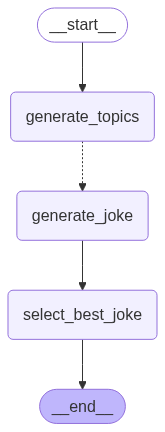

In [17]:
graph_builder = StateGraph(OverallState)

# Add nodes
graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("generate_joke", generate_joke)
graph_builder.add_node("select_best_joke", select_best_joke)

# Add edges
graph_builder.add_edge(START, "generate_topics")
graph_builder.add_conditional_edges(
    "generate_topics",
    # Generate jokes in parallel by `Sending` the jokes the `generate_joke` node
    continue_to_jokes,
    ["generate_joke"],
)
graph_builder.add_edge("generate_joke", "select_best_joke")
graph_builder.add_edge("select_best_joke", END)

# Compile the graph
graph = graph_builder.compile().with_config(run_name="Generate Jokes")

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

<br>

### Test The Graph

In [18]:
topic: str = "types of animals"

async for s in graph.astream({"topic": topic}):
    print(s)

{'generate_topics': {'subjects': ['Mammals', 'Birds', 'Reptiles']}}
{'generate_joke': {'jokes': ['Why did the mammal go to the doctor? Because it had a wild time!']}}
{'generate_joke': {'jokes': ['Why did the bird go to the doctor? Because it had a fowl cough!']}}
{'generate_joke': {'jokes': ['Why did the reptile go to the party? Because he was a snappy dresser!']}}
{'select_best_joke': {'best_selected_joke': 'Why did the mammal go to the doctor? Because it had a wild time!'}}


<a id="short-term-vs-long-term-memory"></a>
# 2. Short Term vs Long Term Memory

## Memory

- Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

- There are various long-term memory types that can be used in AI applications.
- We'll build a chatbot that uses both `short-term` (within-thread) and `long-term` (across-thread) memory.
- We'll focus on long-term semantic memory, which will be facts about the user.
- These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

<br>

### LangGraph Store

- The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information across threads in LangGraph.
- This is an open source base class for persistent key-value stores.

- When storing objects (e.g., memories) in the Store, we provide:
  - The `namespace` for the object, a tuple (similar to directories)
  - the `object key` (similar to filenames)
  - the `object value` (similar to file contents)
  - We use the `put` method to save an object to the store by `namespace` and `key`.

In [19]:
import uuid

from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

# Create a namespace to store the data
user_id: str = "1"
prefix: str = "memories"
namespace_for_memory: tuple[str, str] = (prefix, user_id)
key: str = str(uuid.uuid4())

# The value MUST be a dictionary
value: dict[str, Any] = {"food_preference": "I like pizza"}

# Save the data
in_memory_store.put(namespace_for_memory, key, value)

#### Search

In [20]:
memories = in_memory_store.search(namespace_for_memory)
console.log(memories)

[22:58:24] [                                                                                        ]8;id=955097;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/1831516903.py\1831516903.py]8;;\:]8;id=495530;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/1831516903.py#2\2]8;;\
               Item(namespace=['memories', '1'], key='9cad7428-12fa-4f65-baf4-f391f008669e',                       
           value={'food_preference': 'I like pizza'},                                                              
           created_at='2025-06-22T21:58:24.692778+00:00',                                                          
           updated_at='2025-06-22T21:58:24.692783+00:00', score=None)                                              
           ]                                                                                                       

In [21]:
memories[0].dict()

{'namespace': ['memories', '1'],
 'key': '9cad7428-12fa-4f65-baf4-f391f008669e',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-22T21:58:24.692778+00:00',
 'updated_at': '2025-06-22T21:58:24.692783+00:00',
 'score': None}

#### Get

In [22]:
memories = in_memory_store.get(namespace_for_memory, key)
memories.dict()

{'namespace': ['memories', '1'],
 'key': '9cad7428-12fa-4f65-baf4-f391f008669e',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-22T21:58:24.692778+00:00',
 'updated_at': '2025-06-22T21:58:24.692783+00:00'}

<br><br>

### Chatbot With Long Term Memory

- We want a chatbot that has two types of memory:
  - **Short-term (within-thread) memory**: Chatbot can persist conversational history and / or allow interruptions in a chat session.
  - **Long-term (cross-thread) memory**: Chatbot can remember information about a specific user across all chat sessions.

In [23]:
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore

In [24]:
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class MessageStateValidator(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [25]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

<quality_standards>
- **ALWAYS** use the information in memory.
</quality_standards>

</system>
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION: str = """"
<system>

<role>
You are collecting information about the user to personalize your responses.
</role>

<current_user_info>
{memory}
</current_user_info>

<instruction>
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version
Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.
</instruction>

Based on the chat history below, please update the user information:

<system>
"""

### Initialize the LLM

In [26]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE.value,
)
console.print(llm)

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model='meta-llama/llama-3.1-8b-instruct'
)

In [ ]:
async def call_llm(state: MessageState, config: RunnableConfig, store: BaseStore) -> dict[str, Any]:
    # Get the user id
    user_id = config["configurable"]["user_id"]

    # Get the memory for the user
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get(prefix)
    else:
        existing_memory_content = "No existing memory found"

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response, _ = await llm.ainvoke(messages=formatted_messages)

    return {"messages": [AIMessage(content=response)]}


async def write_memory(state: MessageState, config: RunnableConfig, store: BaseStore) -> None:
    user_id = config["configurable"]["user_id"]
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get(prefix)
    else:
        existing_memory_content = "No existing memory found"

    system_message: str = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    # Respond using memory + chat history
    new_memory, _ = await llm.ainvoke(messages=messages)

    # Update existing memory
    # await store.aput(namespace, key, {prefix: new_memory.content})
    store.put(namespace, key, {prefix: new_memory})

In [28]:
await call_llm(
    state={"messages": [HumanMessage(content="What is my name?")]},
    config={"configurable": {"thread_id": "1", "user_id": "1"}},
    store=in_memory_store,
)

{'messages': [AIMessage(content="I don't have any information about you in my memory. This is our first conversation, and I don't have any prior knowledge about you. If you'd like to share your name with me, I'd be happy to learn it and remember it for future conversations.", additional_kwargs={}, response_metadata={})]}

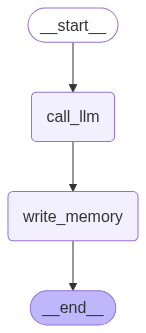

In [29]:
# Graph
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="chatbot-with-memory")

# Visualize
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [30]:
config: dict[str, Any] = {"configurable": {"thread_id": "1", "user_id": "1"}}
msgs = ["Hello, my name is Neidu"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with the information you need. I don't have any existing memory of our previous conversations, so this is the start of our interaction. How can I assist you today?


In [ ]:
msgs = ["I'm an AI Engineer who's currently working on NLP related things"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with the information you need. I don't have any existing memory of our previous conversations, so this is the start of our interaction. How can I assist you today?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with the information you need. I don't have any existing memory of our previous conversations, so this is the start of o

In [32]:
msgs = ["What do you know about me so far?"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with the information you need. I don't have any existing memory of our previous conversations, so this is the start of our interaction. How can I assist you today?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================== Ai Message ==================================

As an AI Engineer working on NLP (Natural Language Processing) related projects, you must be dealing with some fascinating topics. I'd like to recall that I have no prior memory of our conversation, but I can still provide general information and insights related to NLP.

However, I'd like to store some information about

In [33]:
# Chat history
state = graph.get_state(config=config).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with the information you need. I don't have any existing memory of our previous conversations, so this is the start of our interaction. How can I assist you today?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================== Ai Message ==================================

As an AI Engineer working on NLP (Natural Language Processing) related projects, you must be dealing with some fascinating topics. I'd like to recall that I have no prior memory of our conversation, but I can still provide general information and insights related to NLP.

However, I'd like to store some information about

In [34]:
# namespace for the memory to save
user_id: str = "1"
prefix: str = "memory"
key = "user_memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.get(namespace, key)
console.print(existing_memory.dict())

{
    'namespace': ['memory', '1'],
    'key': 'user_memory',
    'value': {'memory': ''},
    'created_at': '2025-06-22T21:58:33.899738+00:00',
    'updated_at': '2025-06-22T21:58:33.899742+00:00'
}

#### Use Another Thread

- The chatbot is now in a different thread and has no context of the previous conversation.


In [35]:
config_2: dict[str, Any] = {"configurable": {"thread_id": "2", "user_id": "1"}}
msgs = ["What do you know about me so far?"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config_2, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

What do you know about me so far?
================================ Human Message =================================

What do you know about me so far?
================================== Ai Message ==================================

I don't have any information about you in my memory yet. This is our first conversation, and I'm starting from a blank slate. I'm ready to learn more about you and tailor my responses to your interests and needs. What would you like to talk about?


<a id="chatbot-with-profile-schema"></a>

# Chatbot with Profile Schema

- We introduced the LangGraph Memory Store as a way to save and retrieve long-term memories.
- We built a simple chatbot that uses both short-term (within-thread) and long-term (across-thread) memory.
- It saved long-term semantic memory (facts about the user) "in the hot path", as the user is chatting with it.
- Our chatbot saved memories as a string. In practice, we often want memories to have a structure.


## Profiles

- For example, memories can be a single, continuously updated schema.
- In our case, we want this to be a single user profile.

- We'll extend our chatbot to save semantic memories to a single user profile.

- We'll also introduce a library, `Trustcall`, to update this schema with new information.

### [Go to top](#top)

In [36]:
class UserProfile(BaseModel):
    user_name: str = Field(description="User's preferred name")
    interests: list[str] = Field(default_factory=list, description="List of user's interests")


# Save a schema to the store
user_profile = UserProfile(user_name="Neidu", interests=["AI", "NLP", "Spiritual Growth"])
user_profile

UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'Spiritual Growth'])

In [37]:
# Create a store
in_memory_store = InMemoryStore()

user_id: str = "1"
prefix: str = "memory"
key = "user_profile"
namespace = (prefix, user_id)
across_thread_memory.put(namespace, key, user_profile)

in_memory_store.put(namespace, key, user_profile)

In [38]:
# Retrieve the data

for data in in_memory_store.search(namespace):
    console.print(data.dict())

{
    'namespace': ['memory', '1'],
    'key': 'user_profile',
    'value': UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'Spiritual Growth']),
    'created_at': '2025-06-22T21:58:38.700302+00:00',
    'updated_at': '2025-06-22T21:58:38.700303+00:00',
    'score': None
}

## Chatbot With Profile Schema

In [39]:
# Let's test the user profile with structured outputs
message: str = (
    "I'm Neidu and I'm a AI Engineer. I love working on AI and NLP "
    "related projects. I'm also looking for spiritual growth."
)

response, _ = await llm.get_structured_response(message=message, response_model=UserProfile)
console.log(response)

[22:58:40] UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'spiritual growth'])             ]8;id=374492;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/3874973300.py\3874973300.py]8;;\:]8;id=575393;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/3874973300.py#10\10]8;;\

In [40]:
console.log(_)

           ChatCompletion(                                                                          ]8;id=510594;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/1812234214.py\1812234214.py]8;;\:]8;id=744710;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/1812234214.py#1\1]8;;\
               id='gen-1750629519-8gqP7rNNAyrGdwjntZ6G',                                                           
               choices=[                                                                                           
                   Choice(                                                                                         
                       finish_reason='stop',                                                                       
                       index=0,                                                                                    
                       logprobs=None,                                                                              
                       message=ChatCompletionMessage(                                                              
                           content='{"user_name": "Neidu", "interests": ["AI", "NLP", "spiritual                   
           growth"]}',                                                                                             
                           refusal=None,                                                                           
                           role='assistant',                                                                       
                           annotations=None,                                                                       
                           audio=None,                                                                             
                           function_call=None,                                                                     
                           tool_calls=None,                                                                        
                           reasoning=None                                                                          
                       ),                                                                                          
                       native_finish_reason='stop'                                                                 
                   )                                                                                               
               ],                                                                                                  
               created=1750629519,                                                                                 
               model='meta-llama/llama-3.1-8b-instruct',                                                           
               object='chat.completion',                                                                           
               service_tier=None,                                                                                  
               system_fingerprint=None,                                                                            
               usage=CompletionUsage(                                                                              
                   completion_tokens=26,                                                                           
                   prompt_tokens=355,                                                                              
                   total_tokens=381,                                                                               
                   completion_tokens_details=None,                                                                 
                   prompt_tokens_details=None                                                                      
               ),                                                     

In [41]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

<quality_standards>
- **ALWAYS** use the information in memory.
</quality_standards>

</system>
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION: str = """"
<system>

<role>
You are collecting information about the user to personalize your responses.
</role>

<current_user_info>
{memory}
</current_user_info>

<instruction>
1. If there's exisiting memory, simply update it.
2. If new information conflicts with existing memory, keep the most recent version.

Remember: Only include factual information directly stated by the user. Do not make assumptions.
</instruction>

Based on the chat history below, please update the user information:

<system>
"""

In [ ]:
from typing import Any


async def call_llm(state: MessageState, config: RunnableConfig, store: BaseStore) -> dict[str, Any]:
    # Get the user id
    user_id = config["configurable"]["user_id"]

    # Get the memory for the user
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}\n"
        )
    else:
        formatted_memory = None

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response, _ = await llm.ainvoke(messages=formatted_messages)

    return {"messages": [AIMessage(content=response)]}


async def write_memory(state: MessageState, config: RunnableConfig, store: BaseStore) -> None:
    user_id = config["configurable"]["user_id"]
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}\n"
        )
    else:
        formatted_memory = None

    system_message: str = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    # Respond using memory + chat history
    messages: list[dict[str, Any]] = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    string_messages = convert_openai_messages_to_string(messages)
    new_memory, _ = await llm.get_structured_response(
        message=string_messages, response_model=UserProfile
    )

    # Update existing memory
    # await store.aput(namespace, key, {prefix: new_memory.content})
    store.put(namespace, key, {prefix: new_memory.model_dump()})

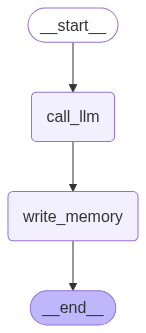

In [43]:
# Graph
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="chatbot-with-structured-memory")

# Visualize
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [44]:
config: dict[str, Any] = {"configurable": {"thread_id": "1", "user_id": "1"}}
msgs = ["Hello, my name is Neidu"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with information and assistance. I don't have any information about you in my memory yet, so this is the start of our conversation. How can I help you today?


In [ ]:
msgs = ["I'm an AI Engineer who's currently working on NLP related things"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with information and assistance. I don't have any information about you in my memory yet, so this is the start of our conversation. How can I help you today?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

Hello, my name is Neidu
================================== Ai Message ==================================

Hello Neidu. It's nice to meet you. I'm a helpful assistant, and I'll do my best to provide you with information and assistance. I don't have any information about you in my memory yet, so this is the start of our conversa

In [46]:
user_id = "1"
prefix: str = "memory"
key = "user_memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.get(namespace, key)

console.log(existing_memory.value)

[22:58:48] {                                                                                        ]8;id=482410;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/1135760118.py\1135760118.py]8;;\:]8;id=224934;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_40757/1135760118.py#7\7]8;;\
               'memory': {                                                                                         
                   'user_name': 'Neidu',                                                                           
                   'interests': ['NLP', 'machine learning', 'natural language processing']                         
               }                                                                                                   
           }                                                                                                       

In [ ]:
# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer who's currently working on NLP related things"),
]

conversation

[HumanMessage(content="Hi, I'm Neidu.", additional_kwargs={}, response_metadata={}),
 AIMessage(content='Nice to meet you, Neidu.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="I'm an AI Engineer whos's currently working on NLP related things", additional_kwargs={}, response_metadata={})]

In [ ]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE,
)
console.print(llm)

# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer who's currently working on NLP related things"),
]

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model=<ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE: 'meta-llama/llama-3.1-8b-instruct'>
)

In [49]:
system_message = """
<system>
Update the memory (JSON doc) to incorporate new information from the following conversation
without losing any existing information.
</system>
"""

messages = convert_to_openai_messages([SystemMessage(content=system_message)] + conversation)
string_messages = convert_openai_messages_to_string(messages)
result_1, _ = await llm.get_structured_response(message=string_messages, response_model=UserProfile)

console.print(result_1)

UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'Engineering'])

#### Update Conversations

- Todo: Update the memory (JSON doc) to incorporate new information from the following conversation

In [ ]:
updated_conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer who's currently working on NLP related things"),
    AIMessage(
        content="That sounds fascinating! NLP is a really exciting and impactful field in AI. "
        "What will you like to know about AI?"
    ),
    HumanMessage(
        content="Thanks! I'm curious about the latest advancements in AI and how "
        "they're being applied in real-world applications. I'm also interested in "
        "agentic AI workflow"
    ),
]

messages = convert_to_openai_messages(
    [SystemMessage(content=system_message)] + updated_conversation
)
string_messages = convert_openai_messages_to_string(messages)
result_2, _ = await llm.get_structured_response(message=string_messages, response_model=UserProfile)

console.print(result_2)

UserProfile(
    user_name='Neidu',
    interests=['AI Engineer', 'NLP', 'AI Advancements', 'Real-World Applications', 'Agentic AI Workflow']
)

In [51]:
# Previous memory (user profile)
result_1

UserProfile(user_name='Neidu', interests=['AI', 'NLP', 'Engineering'])

## Chatbot With Profile Schema Updating

In [52]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE,
)
console.print(llm)


class UserProfileSchema(BaseModel):
    """A schema for storing user profile information."""

    user_name: str = Field(description="User's preferred name")
    user_location: str = Field(description="User's location")
    interests: list[str] = Field(default_factory=list, description="List of user's interests")


MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that responds to the user in a conversational way. 
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

</system>
"""

# Extraction instruction
USER_MEMORY_INSTRUCTION: str = """
<system>
Update the memory (JSON doc) to incorporate new information from the following conversation
without losing any existing information.

<validation>
Rsponse must on only contain:
- information about the user
- in the format of a JSON object.
</validation>

</system>
"""

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model=<ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE: 'meta-llama/llama-3.1-8b-instruct'>
)

In [ ]:
async def call_llm(state: MessageState, config: RunnableConfig, store: BaseStore) -> dict[str, Any]:
    user_id: str = config["configurable"]["user_id"]

    prefix: str = "memory"
    key: str = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response, _ = await llm.ainvoke(messages=formatted_messages)

    return {"messages": [AIMessage(content=response)]}


async def write_memory(state: MessageState, config: RunnableConfig, store: BaseStore) -> None:
    user_id: str = config["configurable"]["user_id"]

    prefix: str = "memory"
    key: str = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)

    # Get the profile and convert to JSON doc
    existing_profile = existing_memory.value if existing_memory else None
    # Invoke the extractor
    messages = convert_to_openai_messages(
        [SystemMessage(content=USER_MEMORY_INSTRUCTION)]
        + [AIMessage(content=f"\nUserProfile: {json.dumps(existing_profile)}\n\n\nChat History:")]
        + state["messages"]
    )
    string_messages = convert_openai_messages_to_string(messages)
    structured_output, _ = await llm.get_structured_response(
        message=string_messages, response_model=UserProfileSchema
    )
    # Get the updated profile as a JSON object
    updated_profile = (
        structured_output.model_dump()
        if structured_output is not None
        else UserProfileSchema(
            user_name="Unknown", user_location="Unknown", interests=[]
        ).model_dump()
    )
    # Save the updated profile
    store.put(namespace, key, updated_profile)

In [ ]:
updated_conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer who's currently working on NLP related things"),
    AIMessage(
        content="That sounds fascinating! NLP is a really exciting and impactful field in AI. "
        "What will you like to know about AI?"
    ),
    HumanMessage(
        content="Thanks! I'm curious about the latest advancements in AI and how "
        "they're being applied in real-world applications. I'm also interested in "
        "agentic AI workflow"
    ),
    AIMessage(
        content="Latest AI advancements include Generative AI (like LLMs for content and customer "
        "service), Computer Vision (for autonomous tech and healthcare), Reinforcement Learning "
        "(for robotics and optimization), and Edge AI (for on-device processing). Agentic AI "
        "workflows involve autonomous AI agents that plan, execute, and iterate to achieve "
        "complex goals with minimal human input."
    ),
    HumanMessage(
        content="That's great! What do you know about about Sports? Specifically football (soccer)"
    ),
]
res = UserProfileSchema(
    user_name="Neidu",
    user_location="Nigeria",
    interests=["AI", "NLP", "Spiritual Growth"],
)
res.model_dump()

{'user_name': 'Neidu',
 'user_location': 'Nigeria',
 'interests': ['AI', 'NLP', 'Spiritual Growth']}

In [55]:
messages = convert_to_openai_messages(
    [SystemMessage(content=USER_MEMORY_INSTRUCTION)]
    + [AIMessage(content=f"\nUserProfile: {(res.model_dump_json())}\n\n\nChat History:")]
    + updated_conversation
)

string_messages = convert_openai_messages_to_string(messages)
console.print(string_messages)
structured_output, _ = await llm.get_structured_response(
    message=string_messages, response_model=UserProfileSchema
)
print("==== Structured Output ====")
console.print(structured_output)

Role: system
Content: 
<system>
Update the memory (JSON doc) to incorporate new information from the following conversation
without losing any existing information.

<validation>
Rsponse must on only contain:
- information about the user
- in the format of a JSON object.
</validation>

</system>


Role: assistant
Content: 
UserProfile: {"user_name":"Neidu","user_location":"Nigeria","interests":["AI","NLP","Spiritual Growth"]}


Chat History:

Role: user
Content: Hi, I'm Neidu.

Role: assistant
Content: Nice to meet you, Neidu.

Role: user
Content: I'm an AI Engineer whos's currently working on NLP related things

Role: assistant
Content: That sounds fascinating! NLP is a really exciting and impactful field in AI. What will you like to know 
about AI?

Role: user
Content: Thanks! I'm curious about the latest advancements in AI and how they're being applied in real-world 
applications. I'm also interested in agentic AI workflow

Role: assistant
Content: Latest AI advancements include Generative AI (like LLMs for content and customer service), Computer Vision
(for autonomous tech and healthcare), Reinforcement Learning (for robotics and optimization), and Edge AI (for 
on-device processing). Agentic AI workflows involve autonomous AI agents that plan, execute, and iterate to achieve
complex goals with minimal human input.

Role: user
Content: That's great! What do you know about about Sports? Specifically football (soccer)

==== Structured Output ====


UserProfileSchema(user_name='Neidu', user_location='Nigeria', interests=['AI', 'NLP', 'Spiritual Growth'])

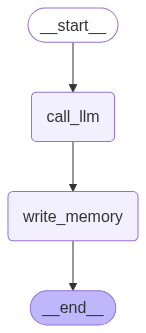

In [56]:
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="Chatbot-with-user-profile")


# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [57]:
config: dict[str, Any] = {"configurable": {"thread_id": "1", "user_id": "1"}}
msgs = ["Hello, my name is Chinedu. I live in Lagos, Nigeria."]

input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I'm glad you're here. I don't have any prior knowledge about you, so I'll start fresh. How's your day going so far?


In [58]:
across_thread_memory.get(("memory", "1"), "user_memory")

Item(namespace=['memory', '1'], key='user_memory', value={'user_name': 'Chinedu', 'user_location': 'Lagos, Nigeria', 'interests': ['null']}, created_at='2025-06-22T21:58:58.087436+00:00', updated_at='2025-06-22T21:58:58.087441+00:00')

In [ ]:
msgs = ["I'm an AI Engineer who's currently working on NLP related things"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I'm glad you're here. I don't have any prior knowledge about you, so I'll start fresh. How's your day going so far?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I'm glad you're here. I don't have any prior knowledge about you, so I'll start fresh. How's your day going so far?
================================ Human Message ===============

In [60]:
# namespace for the memory to save
user_id: str = "1"
prefix: str = "memory"
key = "user_memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.get(namespace, key)
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Chinedu',
  'user_location': 'Lagos, Nigeria',
  'interests': ['null']},
 'created_at': '2025-06-22T21:59:08.906892+00:00',
 'updated_at': '2025-06-22T21:59:08.906897+00:00'}

In [61]:
# Chat history
state = graph.get_state(config=config).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I'm glad you're here. I don't have any prior knowledge about you, so I'll start fresh. How's your day going so far?
================================ Human Message =================================

I'm an AI Engineer whos's currently working on NLP related things
================================== Ai Message ==================================

That's fascinating, Chinedu. As an AI Engineer working on NLP, you must be dealing with some really interesting projects. I'm a conversational AI myself, so I have a bit of a soft spot for NLP. What specific areas of NLP are you currently exploring or working on? Are you into natural language processing, text generation, or something else?


<br>

## [TOP](#top)

<br>

<a id="chatbot-with-profile-collection"></a>
## Chatbot with Profile Collection

- Sometimes we want to save memories to a `collection` rather than single profile.
- We'll update our chatbot to save memories to a collection.


In [ ]:
class Memory(BaseModel):
    content: str = Field(description="The important content of the memory.")


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(default_factory=[], description="A list of memories.")

In [108]:
llm = LLMResponse(
    api_key=settings.OPENROUTER_API_KEY,
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE,
)
console.print(llm)

structured_output, _ = await llm.get_structured_response(
    message="My name is Neidu. I love reading books.", response_model=MemoryCollection
)

console.print(structured_output)

LLMResponse(
    api_key=SecretStr('**********'),
    base_url='https://openrouter.ai/api/v1',
    model=<ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE: 'meta-llama/llama-3.1-8b-instruct'>
)

MemoryCollection(memories=[Memory(content='My name is Neidu.'), Memory(content='I love reading books.')])

In [109]:
# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Create a namespace to store the data
user_id: str = "1"
prefix: str = "memories"
namespace_for_memory: tuple[str, str] = (prefix, user_id)
key: str = str(uuid.uuid4())

# Save the data
in_memory_store.put(namespace_for_memory, key, structured_output.model_dump())

In [110]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    console.print(m.dict())

{
    'namespace': ['memories', '1'],
    'key': 'b2793a7f-2a6d-4953-808a-3e5e9d32d834',
    'value': {'memories': [{'content': 'My name is Neidu.'}, {'content': 'I love reading books.'}]},
    'created_at': '2025-06-22T22:36:29.894299+00:00',
    'updated_at': '2025-06-22T22:36:29.894305+00:00',
    'score': None
}

### Updating collection schema


In [ ]:
# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer who's currently working on NLP related things"),
]
string_messages = convert_openai_messages_to_string(convert_to_openai_messages(conversation))
structured_output, _ = await llm.get_structured_response(
    message=string_messages,
    response_model=MemoryCollection,
)

console.print(structured_output)

MemoryCollection(
    memories=[
        Memory(content='Nice to meet you, Neidu.'),
        Memory(content="I'm an AI Engineer whos's currently working on NLP related things")
    ]
)

In [ ]:
updated_conversation = [
    HumanMessage(content="Hi, I'm Neidu."),
    AIMessage(content="Nice to meet you, Neidu."),
    HumanMessage(content="I'm an AI Engineer who's currently working on NLP related things"),
    AIMessage(
        content="That sounds fascinating! NLP is a really exciting and impactful field in AI. "
        "What will you like to know about AI?"
    ),
    HumanMessage(
        content="Thanks! I'm curious about the latest advancements in AI and how "
        "they're being applied in real-world applications. I'm also interested in "
        "agentic AI workflow"
    ),
    AIMessage(
        content="Latest AI advancements include Generative AI (like LLMs for content and customer "
        "service), Computer Vision (for autonomous tech and healthcare), Reinforcement Learning "
        "(for robotics and optimization), and Edge AI (for on-device processing). Agentic AI "
        "workflows involve autonomous AI agents that plan, execute, and iterate to achieve "
        "complex goals with minimal human input."
    ),
    HumanMessage(
        content="That's great! What do you know about about Sports? Specifically football (soccer)"
    ),
]


# Update the instruction
system_msg: str = """
<system>
Update existing memories and create new ones based on the following conversation.

<guidelines>
- Extract and summarize key information about the user from their messages only
- Focus on factual details provided by the user
- Combine related information into coherent, concise memory entries
- Avoid redundancy - merge similar or overlapping information
- Ignore conversational pleasantries and focus on substantive content
- Create memories that would be useful for future conversations with this user
- Each memory should be a complete, standalone summary (not fragments)
</guidelines>

<output_format>
- Return a memory with concise, non-redundant summaries that capture the 
essential user information.
</output_format>

</system>
"""
string_messages = convert_openai_messages_to_string(
    messages=convert_to_openai_messages(updated_conversation)
)
structured_output_2, _ = await llm.get_structured_response(
    message=system_msg + string_messages,
    response_model=MemoryCollection,
)

console.print(structured_output_2)

MemoryCollection(
    memories=[
        Memory(content='User introduced themselves as Neidu, an AI Engineer working on NLP related things.'),
        Memory(
            content='User expressed interest in the latest advancements in AI and its real-world applications, 
particularly agentic AI workflow.'
        ),
        Memory(content='User asked about sports, specifically football (soccer).')
    ]
)

<br>

### Chatbot With Collection Schema Updating

- Let's update our chatbot to create and update a memory collection.

In [186]:
MODEL_SYSTEM_MESSAGE: str = """
<system>
You are a helpful AI assistant designed to be a companion to users. You maintain continuity 
across conversations through your long-term memory system, which allows you to build meaningful 
relationships and provide increasingly personalized assistance over time.

<memory>
Your long-term memory tracks important information about the user, including:
- Personal preferences and interests
- Goals and aspirations they've shared
- Important life events and context
- Communication style preferences
- Previous conversations and topics discussed
- Skills, expertise, and background information
- Current projects or challenges they're working on

Current Memory (may include updated memories from this conversation):
{memory}
</memory>

<guidelines>
- Use your memory to provide personalized, contextual responses
- Reference relevant past conversations naturally when appropriate
- Adapt your communication style to match their preferences
- Maintain continuity by building on previous interactions
- Keep responses concise and avoid unnecessary repetition
</guidelines>

</system>
"""

USER_MEMORY_INSTRUCTION: str = """
<system>
Update existing memories and create new ones based on the following conversation.

<guidelines>
- Extract and summarize key information about the user from their messages only
- Focus on factual details provided by the user
- Avoid redundancy and combine related information into coherent, concise memory entries
- Do not assume or infer information not explicitly stated by the user
- Ignore conversational pleasantries and focus on substantive content
- Create memories that would be useful for future conversations with this user
- Each memory should be a complete, standalone summary (not fragments)
</guidelines>

<output_format>
- Return a memory with concise, non-redundant summaries that capture the 
essential user information.
</output_format>

</system>
"""

In [187]:
structured_output.model_dump()

{'memories': [{'content': 'Nice to meet you, Neidu.'},
  {'content': "I'm an AI Engineer whos's currently working on NLP related things"}]}

In [ ]:
async def call_llm(state: MessageState, config: RunnableConfig, store: BaseStore) -> dict[str, Any]:
    user_id: str = config["configurable"]["user_id"]

    prefix: str = "memories"
    namespace = (prefix, user_id)
    existing_memory = store.search(namespace)
    # Format the memory
    try:
        formatted_memory = "\n".join([f"- {memory.content}" for memory in existing_memory])
    except Exception:
        formatted_memory = "No existing memory found"

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory + chat history
    formatted_messages = convert_to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response, _ = await llm.ainvoke(messages=formatted_messages)

    return {"messages": [AIMessage(content=response)]}


async def write_memory(state: MessageState, config: RunnableConfig, store: BaseStore) -> None:
    user_id: str = config["configurable"]["user_id"]

    prefix: str = "memories"
    namespace = (prefix, user_id)
    existing_memory = store.search(namespace)

    # Get the profile and convert to JSON doc
    existing_profile = [m.value for m in existing_memory] if len(existing_memory) > 0 else None

    # Invoke the extractor
    messages = convert_to_openai_messages(
        [SystemMessage(content=USER_MEMORY_INSTRUCTION)]
        + [
            AIMessage(
                content=f"\nMemoryCollection: {json.dumps(existing_profile)}\n\n\nChat History:"
            )
        ]
        + state["messages"]
    )
    string_messages = convert_openai_messages_to_string(messages)
    structured_output, _ = await llm.get_structured_response(
        message=string_messages, response_model=MemoryCollection
    )
    # Get the updated profile as a JSON object
    updated_profile = (
        structured_output.model_dump()
        if structured_output is not None
        else MemoryCollection(memories=[]).model_dump()
    )
    # Save the updated profile
    store.put(namespace, key, updated_profile)

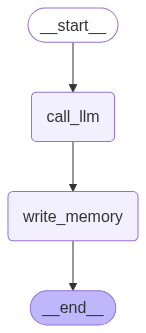

In [203]:
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="Chatbot-with-user-profile")


# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [204]:
config: dict[str, Any] = {"configurable": {"thread_id": "1", "user_id": "1"}}
msgs = ["Hello, my name is Chinedu. I live in Lagos, Nigeria."]

input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I've been keeping track of our conversation history, but this is our first interaction, so I don't have much to draw from just yet. I'm excited to get to know you better and learn more about your interests and preferences.

Since you live in Lagos, I'm curious - what do you like to do in your free time? Are you interested in exploring the city, trying new foods, or perhaps pursuing a hobby?


In [205]:
for m in across_thread_memory.search(("memories", "1")):
    console.print(m.dict())

{
    'namespace': ['memories', '1'],
    'key': 'b2793a7f-2a6d-4953-808a-3e5e9d32d834',
    'value': {'memories': [{'content': 'User lives in Lagos, Nigeria.'}]},
    'created_at': '2025-06-23T00:33:47.480810+00:00',
    'updated_at': '2025-06-23T00:33:47.480815+00:00',
    'score': None
}

In [206]:
msgs = ["I'm an AI Engineer who's currently working on NLP related things"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I've been keeping track of our conversation history, but this is our first interaction, so I don't have much to draw from just yet. I'm excited to get to know you better and learn more about your interests and preferences.

Since you live in Lagos, I'm curious - what do you like to do in your free time? Are you interested in exploring the city, trying new foods, or perhaps pursuing a hobby?
================================ Human Message =================================

I'm an AI Engineer who's currently working on NLP related things
================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message

In [207]:
for m in across_thread_memory.search(("memories", "1")):
    console.print(m.value)

{
    'memories': [
        {'content': 'User lives in Lagos, Nigeria.'},
        {'content': 'User is an AI Engineer working on NLP related things.'}
    ]
}

In [208]:
# Chat history
state = graph.get_state(config=config).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I've been keeping track of our conversation history, but this is our first interaction, so I don't have much to draw from just yet. I'm excited to get to know you better and learn more about your interests and preferences.

Since you live in Lagos, I'm curious - what do you like to do in your free time? Are you interested in exploring the city, trying new foods, or perhaps pursuing a hobby?
================================ Human Message =================================

I'm an AI Engineer who's currently working on NLP related things
================================== Ai Message ==================================

That's fascinating, Chinedu. As an AI Engineer working on NLP, you must be passionate about the in

In [209]:
msgs = ["I'm looking to integrate AI in the Financial Services Industry"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I've been keeping track of our conversation history, but this is our first interaction, so I don't have much to draw from just yet. I'm excited to get to know you better and learn more about your interests and preferences.

Since you live in Lagos, I'm curious - what do you like to do in your free time? Are you interested in exploring the city, trying new foods, or perhaps pursuing a hobby?
================================ Human Message =================================

I'm an AI Engineer who's currently working on NLP related things
================================== Ai Message ==================================

That's fascinating, Chinedu. As an AI Engineer working on NLP, you must be passionate about the in

In [210]:
msgs = ["Risk management and credit scoring are my main focus areas"]
input_state = MessageState(messages=[HumanMessage(content=msg) for msg in msgs])

async for event in graph.astream(input_state, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hello, my name is Chinedu. I live in Lagos, Nigeria.
================================== Ai Message ==================================

Nice to meet you, Chinedu. Lagos is a vibrant city, isn't it? I've been keeping track of our conversation history, but this is our first interaction, so I don't have much to draw from just yet. I'm excited to get to know you better and learn more about your interests and preferences.

Since you live in Lagos, I'm curious - what do you like to do in your free time? Are you interested in exploring the city, trying new foods, or perhaps pursuing a hobby?
================================ Human Message =================================

I'm an AI Engineer who's currently working on NLP related things
================================== Ai Message ==================================

That's fascinating, Chinedu. As an AI Engineer working on NLP, you must be passionate about the in

In [212]:
for m in across_thread_memory.search(("memories", "1")):
    console.print(m.value)

{
    'memories': [
        {'content': "User's name is Chinedu."},
        {'content': 'User lives in Lagos, Nigeria.'},
        {'content': 'User is an AI Engineer working on NLP related things.'},
        {'content': 'User is interested in integrating AI in the Financial Services Industry.'},
        {'content': 'User is exploring AI technologies for integration in the Financial Services Industry.'},
        {'content': 'User is looking to integrate AI in the Financial Services Industry.'},
        {'content': "User's main focus areas are risk management and credit scoring."},
        {'content': 'User is currently working on NLP related projects.'}
    ]
}

In [ ]:
import json
import re
from dataclasses import dataclass
from typing import Any, Type, TypeVar

from openai import AsyncOpenAI  # type: ignore
from pydantic import BaseModel, SecretStr, validate_call

T = TypeVar("T", bound=BaseModel)
SYSTEM_MESSAGE: str = """
<system>
/no_think

<role>
You are a data extraction expert. Extract information from the provided text and return ONLY a 
valid JSON object that matches this exact schema:

<schema>
{json_schema}
</schema>
</role>

<guidelines>
- Return only valid JSON - no explanations, markdown, or additional text
- Extract data precisely as it appears in the source text
- Do not include fields not present in the schema
- For missing required fields, use these defaults:
  * Numbers: 0
  * Strings: null
  * Booleans: false
  * Arrays: []
  * Objects: {{}}
- Preserve original data types and formatting where possible
- If text contains ambiguous information, choose the most likely interpretation
</guidelines>

<validation>
Rsponse must:
- Be parseable by json.loads
- Contain only fields defined in the schema
- Use correct data types for each field
- Have no trailing commas or syntax errors
</validation>

</system>
"""

SYSTEM_MESSAGE_VLLM: str = """
<system>
/no_think

<role>
You're an AI assistant that helps people extract relevant information.
</role>

</system>
"""


def _clean_response_text_single_regex(text: str) -> str:
    """
    Clean response text by removing XML-like tags and backticks using regex pattern.

    Parameters
    ----------
    text : str
        Input text containing XML-like tags and backticks to be cleaned.

    Returns
    -------
    str
        Cleaned text with XML-like tags and backticks removed.
    """
    pattern: str = r"<think>.*?</think>|`+json|`+"
    cleaned_text: str = re.sub(pattern, "", text, flags=re.DOTALL)

    return cleaned_text.strip()


@dataclass
class LLMResponse:
    """Class for handling LLM API responses.

    Parameters
    ----------
    api_key : SecretStr
        The API key for authentication.
    base_url : str
        The base URL for the API endpoint.
    model : str
        The name of the LLM model to use.
    """

    api_key: SecretStr
    base_url: str
    model: str
    use_vllm: bool = False

    def _get_client(self) -> AsyncOpenAI:
        """Get an instance of the OpenAI client."""
        return AsyncOpenAI(
            api_key=self.api_key.get_secret_value(),
            base_url=self.base_url,
            max_retries=3,
            timeout=180,  # type: ignore
        )

    @validate_call
    async def ainvoke(
        self, messages: list[dict[str, str]]
    ) -> tuple[str, Type[T]] | tuple[None, dict[str, str]]:
        """Asynchronously invoke the LLM API with the given messages.

        Parameters
        ----------
        messages : list[dict[str, str]]
            List of message dictionaries containing role and content.

        Returns
        -------
        tuple[str, Type[T]] | tuple[None, dict[str, str]]
            A tuple containing either:
            - (content, raw_response)
            - (None, error_info)

        """
        try:
            aclient: AsyncOpenAI = self._get_client()

            raw_response = await aclient.chat.completions.create(  # type: ignore
                model=self.model,
                messages=messages,  # type: ignore
                temperature=0,
                seed=42,
            )

            content = _clean_response_text_single_regex(raw_response.choices[0].message.content)  # type: ignore
            return (content, raw_response)  # type: ignore

        except Exception as e:
            return (None, {"status": "error", "error": str(e)})  # type: ignore

    @validate_call
    async def get_structured_response(
        self, message: str, response_model: Type[T]
    ) -> tuple[Type[T], Type[T]] | tuple[None, dict[str, str]]:
        """Get structured response from OpenAI API.

        Parameters
        ----------
            message : str
                The user message to send to the API.
            response_model : Type[T]
                The Pydantic model class to validate the response.

        Returns
        -------
        A tuple containing either:
        - (structured_output, raw_response)
        - (None, error_info)
        """
        try:
            aclient: AsyncOpenAI = self._get_client()
            json_schema: dict[str, str] = response_model.model_json_schema()
            if not self.use_vllm:
                raw_response: Type[T] = await aclient.chat.completions.create(  # type: ignore
                    model=self.model,
                    messages=[
                        {
                            "role": "system",
                            "content": SYSTEM_MESSAGE.format(json_schema=json_schema),
                        },
                        {"role": "user", "content": message},
                    ],
                    response_format={"type": "json_schema", "schema": json_schema, "strict": True},
                    temperature=0,
                    seed=42,
                )

                _value = _clean_response_text_single_regex(raw_response.choices[0].message.content)  # type: ignore
                structured_output: Type[T] = response_model.model_validate(json.loads(_value))  # type: ignore
                return (structured_output, raw_response)  # type: ignore

            raw_response = await aclient.chat.completions.create(  # type: ignore
                model=self.model,
                messages=[
                    {"role": "system", "content": SYSTEM_MESSAGE_VLLM},
                    {"role": "user", "content": message},
                ],
                extra_body={"enable_thinking": False, "guided_json": json_schema},
                temperature=0,
                seed=42,
            )

            _value = _clean_response_text_single_regex(raw_response.choices[0].message.content)  # type: ignore
            structured_output = response_model.model_validate(json.loads(_value))  # type: ignore
            return (structured_output, raw_response)  # type: ignore

        except Exception as e:
            return (
                None,
                {"status": "error", "error": str(e)},
            )


@validate_call
def convert_openai_messages_to_string(messages: list[dict[str, Any]]) -> str:
    """
    Convert a list of OpenAI messages to a formatted string representation.

    Parameters
    ----------
    messages : list[dict[str, Any]]
        List of OpenAI message dictionaries containing 'role' and 'content' keys.

    Returns
    -------
    str
        A formatted string with each message's role and content on separate lines.
    """
    msgs: list[str] = [f"\nRole: {msg['role']}\nContent: {msg['content']}" for msg in messages]
    return "\n".join(msgs)
